<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/project%5CKalman_Filters_for_Stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
!pip install pykalman
!pip install yfinance
!pip install pandas-ta==0.2.45b

In [57]:
#Importing dependencies#
from pykalman import KalmanFilter
import numpy as np
import pylab as pl
import pandas as pd
import yfinance as yf
from scipy import poly1d
from datetime import datetime
import pandas_ta as ta
import matplotlib.pyplot as plt
%matplotlib inline

[*********************100%***********************]  1 of 1 completed


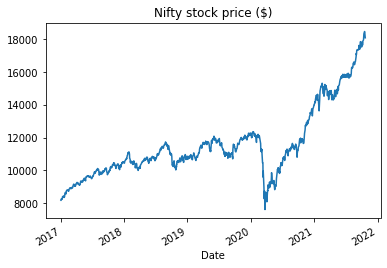

In [58]:
#ticker= yf.Ticker('TSLA')
nifty_df = yf.download('^nsei',start='2017-01-01')
nifty_df['Adj Close'].plot(title='Nifty stock price ($)');


In [59]:
#nifty_df = yf.download('sbin.ns',start='2014-01-01',progress=False)


In [60]:
df = nifty_df[['Adj Close']]


mean 15684.84444270402


Text(0.5, 0, 'Days')

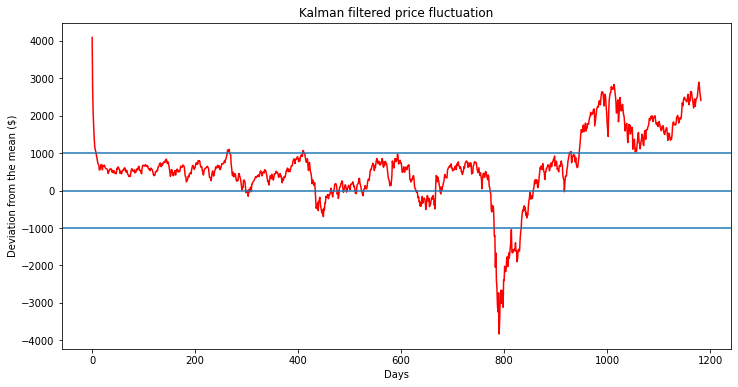

In [61]:
f = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance = 1,
                  transition_covariance = 0.0001)
mean, cov = f.filter(df['Adj Close'].values)
mean, std = mean.squeeze(), np.std(cov.squeeze())
print(f'mean {mean[-1]}')


plt.figure(figsize=(12,6))
plt.plot(df['Adj Close'].values - mean, 'red', lw=1.5)

plt.axhline(y=0)
plt.axhline(y=1000)
plt.axhline(y=-1000)
plt.title("Kalman filtered price fluctuation")
plt.ylabel("Deviation from the mean ($)")
plt.xlabel("Days")

In [62]:
nifty =pd.DataFrame({'Date': nifty_df.index,'Close':df['Adj Close'].values - mean})


In [63]:
nifty['30 Day MA'] = nifty['Close'].rolling(window=20).mean()
# set .std(ddof=0) for population std instead of sample
nifty['30 Day STD'] = nifty['Close'].rolling(window=20).std() 
nifty['Upper Band'] = nifty['30 Day MA'] + (nifty['30 Day STD'] *0.5)
nifty['Lower Band'] = nifty['30 Day MA'] - (nifty['30 Day STD'] *0.5)

nifty.ta.macd(append=True)

print()

In [68]:
nifty

,close,30 Day MA,30 Day STD,Upper Band,Lower Band,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
date,,,,,,,,
2017-02-17,523.811759,596.113539,67.231516,629.729297,562.497781,-237.829557,44.151482,-281.981039
2017-02-20,564.501423,597.007243,66.655408,630.334947,563.679539,-221.719411,48.209303,-269.928714
2017-02-21,576.424197,598.136462,66.074383,631.173654,565.099271,-205.619680,51.447227,-257.066907
2017-02-22,579.087024,596.973970,66.200997,630.074469,563.873472,-190.450267,53.293312,-243.743579
2017-02-23,575.783039,591.239184,62.541363,622.509865,559.968502,-176.658592,53.667989,-230.326582
...,...,...,...,...,...,...,...,...
2021-10-18,2896.396834,2480.170660,178.895879,2569.618599,2390.722720,113.005712,32.840314,80.165397
2021-10-19,2809.856642,2506.076756,187.480975,2599.817243,2412.336268,124.230285,35.251910,88.978375
2021-10-20,2631.261742,2516.020417,188.637358,2610.339095,2421.701738,117.361850,22.706780,94.655070


In [65]:
nifty=nifty.set_index('date')

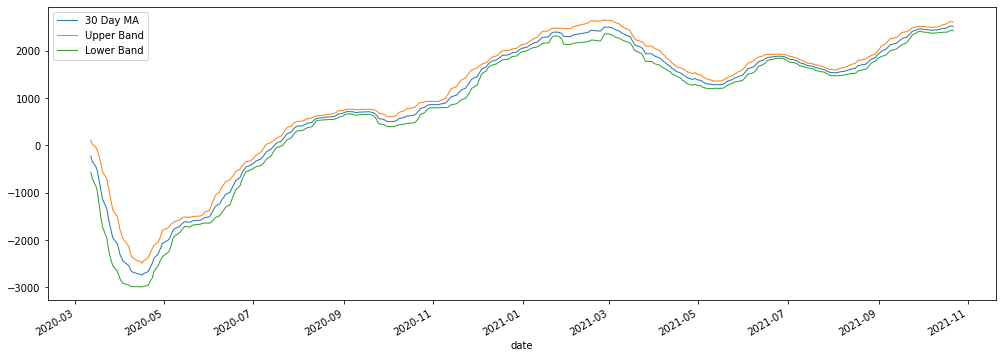

In [67]:
nifty[['30 Day MA', 'Upper Band', 'Lower Band']][-400:].plot(figsize=(17,6),linewidth=1);

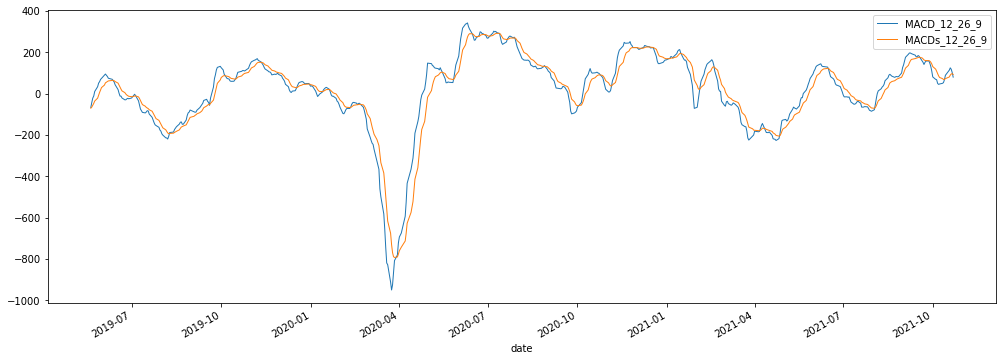

In [70]:
nifty[['MACD_12_26_9','MACDs_12_26_9']][-600:].plot(figsize=(17,6),linewidth=1);